In [176]:
# import the necessary packages
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb
import numpy as np
import cv2
import imutils
from skimage.measure import compare_ssim

#### Get a cropped image of a pot and create a black mask of it 

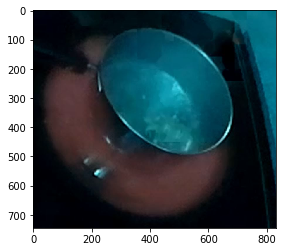

In [27]:
# image of a boiling pot
burnerBoil = cv2.imread('../../Desktop/BurnerBoil.jpg')
copy = burnerBoil.copy()

# convert to single channel image to create a mask
copy1 = cv2.cvtColor(burnerBoil.copy(), cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(copy1)

plt.imshow(burnerBoil)
plt.show()

#### Convert one of image copies to grayscale and threshold it
  * Creates a binary image threshold

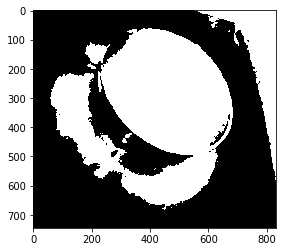

In [15]:
imgray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
# get a binary threshold of the image
(thresh, im_bw) = cv2.threshold(imgray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(im_bw,cmap=cm.gray)
plt.show()

####  Creates a list of contours from threshed image

In [16]:
# creates list of contours from thresholded image
contours,_= cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_list = []

# finds the circular shapes
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (area > 30) ):
        contour_list.append(contour)

#### Used to visualize the contours

In [5]:
color = 50
cnt = 0
copy_clean = copy.copy()
for contour in contours:
    cv2.drawContours(copy, contour, -1, (0,0,color), 5)
    color = color + 20
    #plt.imshow(copy)
    #plt.show()
    #print(cnt)
    copy = copy_clean.copy()
    cnt = cnt + 1

#### Confirms the largest contour is the one we want

In [17]:
sortedContours = sorted(contours, key=cv2.contourArea, reverse=True)
cnt = sortedContours[0]
print(cv2.contourArea(cnt))
print(cv2.contourArea(contours[39]))

216619.5
216619.5


In [6]:
# Use the largest contour (need a function for this later) and fit an ellipse from it 
cnt = contours[39]
ellipse = cv2.fitEllipse(cnt)

In [24]:
# Unpack the properties of the returned ellipse
x = int(ellipse[0][0]) # x coordinate of the center
y = int(ellipse[0][1]) # y coordinate of the center
a = int(ellipse[1][0] / 2) # major semi-axis
b = int(ellipse[1][1] / 2) # minor semi-axis
theta = int(ellipse[2]) # rotation angle

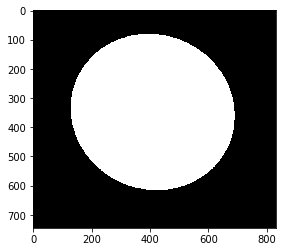

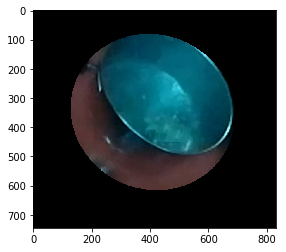

In [28]:
# Draw a filled ellipse onto the originally black mask
cv2.ellipse(mask, (x,y), (a,b), theta, 0,360,((255,255,255)),-1)
plt.imshow(mask, cmap=cm.gray)
plt.show()
copy = cv2.bitwise_and(copy,copy,mask=mask)
plt.imshow(copy, cmap=cm.gray)
plt.show()

## Create a function that performs the above masking

In [155]:
def maskPot(img):
    copy = img.copy()
    gray_img = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_img,cmap=cm.gray)
    plt.show()
    # increase the contrast in the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray_img)
    plt.imshow(cl1,cmap=cm.gray)
    plt.show()
    #cl1 = cv2.equalizeHist(gray_img)
    #plt.imshow(cl1,cmap=cm.gray)
    #plt.show()
    # create a black mask
    mask = np.zeros_like(gray_img)
    # thresh
    (thresh, im_bw) = cv2.threshold(cl1, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # find contours
    plt.imshow(im_bw,cmap=cm.gray)
    plt.show()
    contours,_= cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort the contours from largest area to smallest
    sortedContours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = sortedContours[0]
    
    # fit an ellipse to the largest contour
    ellipse = cv2.fitEllipse(cnt)
    # Unpack the properties of the returned ellipse
    x = int(ellipse[0][0]) # x coordinate of the center
    y = int(ellipse[0][1]) # y coordinate of the center
    a = int(ellipse[1][0] / 2) # major semi-axis
    b = int(ellipse[1][1] / 2) # minor semi-axis
    theta = int(ellipse[2]) # rotation angle
    
    # draw the found ellipsed onto the mask
    cv2.ellipse(mask, (x,y), (a,b), theta, 0,360,((255,255,255)),-1)
    # mask the input image copy
    copy = cv2.bitwise_and(copy,copy,mask=mask)
    return copy

### Use the function maskPot()

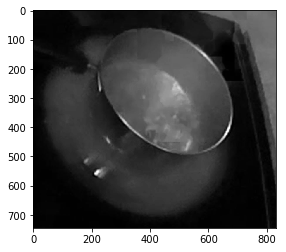

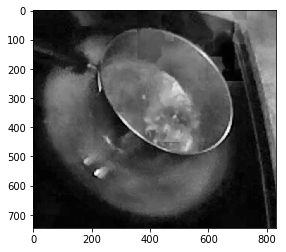

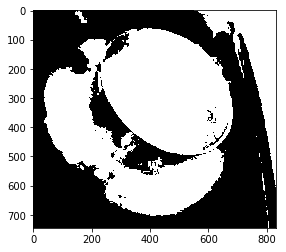

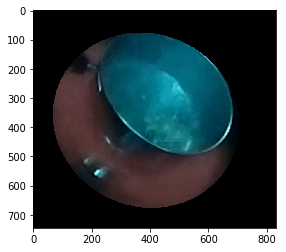

In [156]:
img = cv2.imread('../../Desktop/BurnerBoil.jpg')
masked_img = maskPot(img)
plt.imshow(masked_img)
plt.show()

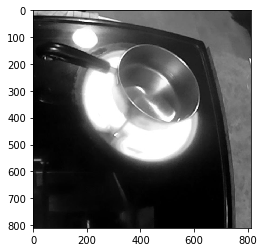

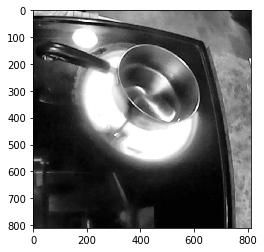

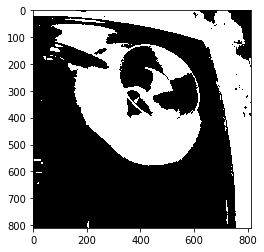

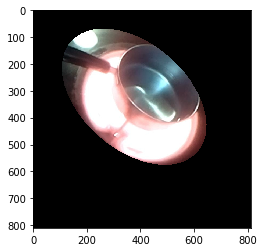

In [157]:
img = cv2.imread('../../Desktop/BurnerNoBoil.jpg')
masked_img = maskPot(img)
plt.imshow(masked_img)
plt.show()

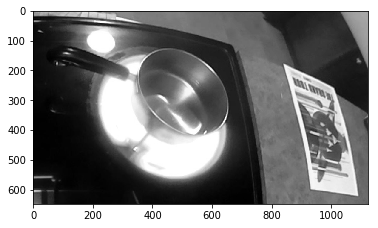

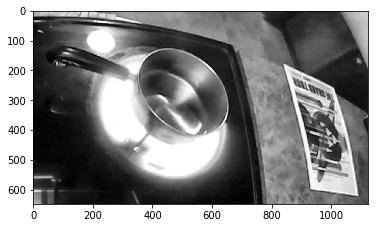

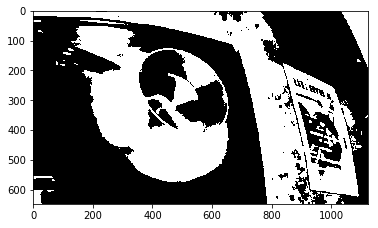

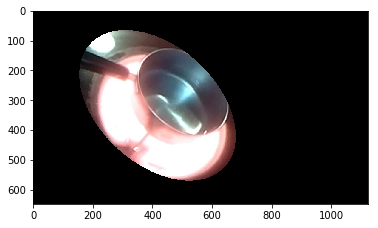

In [158]:
img = cv2.imread('../../Desktop/BurnerBoilCrop.jpg')
masked_img = maskPot(img)
plt.imshow(masked_img)
plt.show()

### The following maskPot2() function blurs the image as well as performing the same function as maskPot()

In [142]:
def maskPot2(img):
    copy = img.copy()
    kernel = np.ones((15,15), np.uint8)
    gray_img = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray_img,cmap=cm.gray)
    #plt.show()
    # create a black mask
    mask = np.zeros_like(gray_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray_img)
    #plt.imshow(cl1,cmap=cm.gray)
    #plt.show()

    blur = cv2.GaussianBlur(cl1,(15,15),0)
    blur = cv2.erode(blur,kernel,iterations =1)
    blur = cv2.dilate(blur,kernel,iterations =1)
    #plt.imshow(blur,cmap=cm.gray)
    #plt.show()
    ret, im_bw = cv2.threshold(blur, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #plt.imshow(im_bw,cmap=cm.gray)
    #plt.show()   
    
    contours,_= cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort the contours from largest area to smallest
    sortedContours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = sortedContours[0]
    
    # fit an ellipse to the largest contour
    ellipse = cv2.fitEllipse(cnt)
    # Unpack the properties of the returned ellipse
    x = int(ellipse[0][0]) # x coordinate of the center
    y = int(ellipse[0][1]) # y coordinate of the center
    a = int(ellipse[1][0] / 2) # major semi-axis
    b = int(ellipse[1][1] / 2) # minor semi-axis
    theta = int(ellipse[2]) # rotation angle
    
    # draw the found ellipsed onto the mask
    cv2.ellipse(mask, (x,y), (a,b), theta, 0,360,((255,255,255)),-1)
    # mask the input image copy
    copy = cv2.bitwise_and(copy,copy,mask=mask)
    return copy

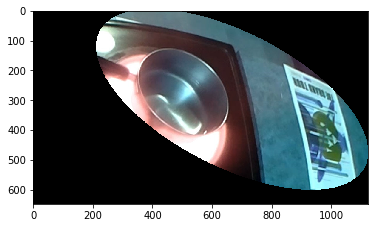

In [143]:
img = cv2.imread('../../Desktop/BurnerBoilCrop.jpg')
masked_img = maskPot2(img)
plt.imshow(masked_img)
plt.show()

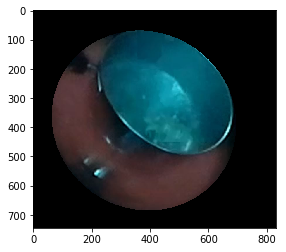

In [144]:
img = cv2.imread('../../Desktop/BurnerBoil.jpg')
masked_img = maskPot2(img)
plt.imshow(masked_img)
plt.show()

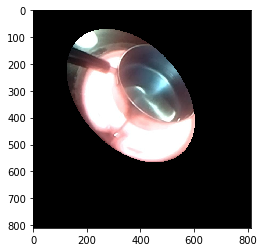

In [145]:
img = cv2.imread('../../Desktop/BurnerNoBoil.jpg')
masked_img = maskPot2(img)
plt.imshow(masked_img)
plt.show()

### Performing SSIM Comparison

In [188]:
# takes two images and finds the SSIM between them
def compareImages(gray1, gray2):
    # compute the Structural Similarity Index (SSIM) between the two
    # images, ensuring that the difference image is returned
    (score, diff) = compare_ssim(gray1, gray2, full=True)
    diff = (diff * 255).astype("uint8")
    
    # threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(gray1, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.rectangle(gray2, (x, y), (x + w, y + h), (0, 0, 255), 2)

    plt.imshow(diff,cmap=cm.gray)
    plt.show()
    plt.imshow(thresh,cmap=cm.gray)
    plt.show()
    plt.imshow(gray1,cmap=cm.gray)
    plt.show()
    plt.imshow(gray2,cmap=cm.gray)
    plt.show()
    return score

In [197]:
video = "..\\..\\Desktop\\boiling_short.h264"
cap = cv2.VideoCapture(video)

frameCount = 0 # wait till at a stable beginning
initial = True
while cap.isOpened():
    retTemp, frameTemp = cap.read();

    # if it is the first time then two frames must be recorded
    if initial:
        ret1 = retTemp
        frameOld = frameTemp
        ret2, frameNew = cap.read()
        initial = False
        frameCount += 1
    elif(frameCount == 6000): # should be boiling
        captured = frameNew
        captured2 = frameTemp
        frameCount += 1
        break
        # checks the frame count to see if time to collect a new one
    else:
        ret1 = ret2
        frameOld = frameNew
        ret2 = retTemp
        frameNew = frameTemp
        frameCount += 1

cap.release()

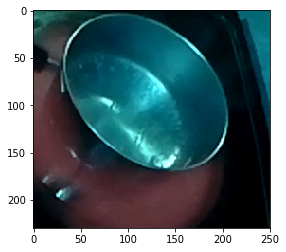

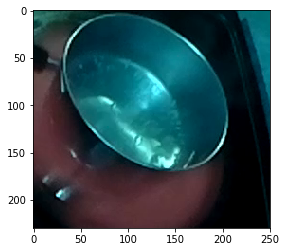

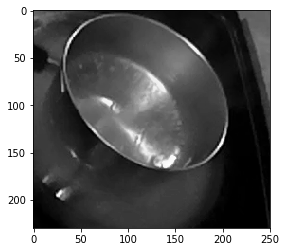

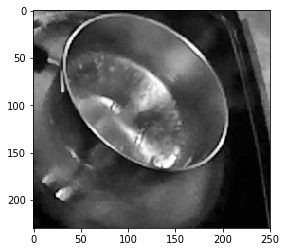

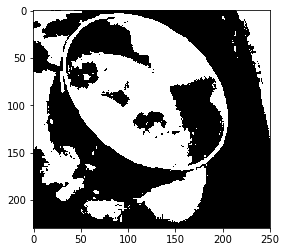

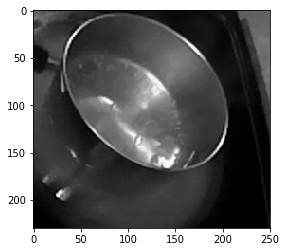

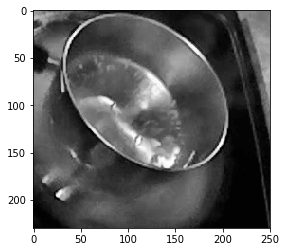

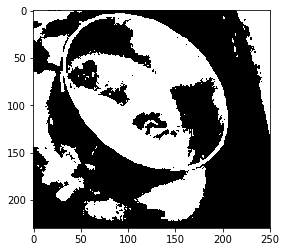

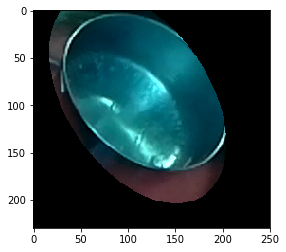

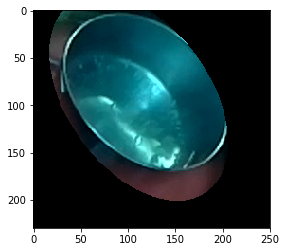

In [198]:
crop1 = captured[70:300, 800:1050]
plt.imshow(crop1)
plt.show()
crop2 = captured2[70:300, 800:1050]
plt.imshow(crop2)
plt.show()
# gets a masked version of the images
mask1 = maskPot(crop1)
mask2 = maskPot(crop2)
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

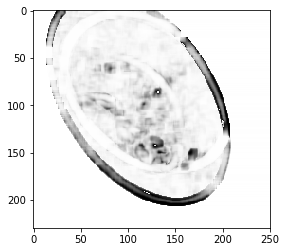

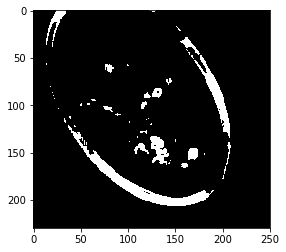

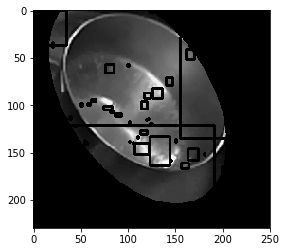

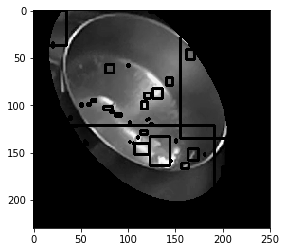


SSIM: 0.9237645252778578


In [199]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

In [207]:
video = "..\\..\\Desktop\\boiling_short.h264"
cap = cv2.VideoCapture(video)

frameCount = 0 # wait till at a stable beginning
initial = True
while cap.isOpened():
    retTemp, frameTemp = cap.read();

    # if it is the first time then two frames must be recorded
    if initial:
        ret1 = retTemp
        frameOld = frameTemp
        ret2, frameNew = cap.read()
        initial = False
        frameCount += 1
    elif(frameCount == 2000): # should not be boiling
        captured = frameNew
        captured2 = frameTemp
        frameCount += 1
        break
        # checks the frame count to see if time to collect a new one
    else:
        ret1 = ret2
        frameOld = frameNew
        ret2 = retTemp
        frameNew = frameTemp
        frameCount += 1

cap.release()

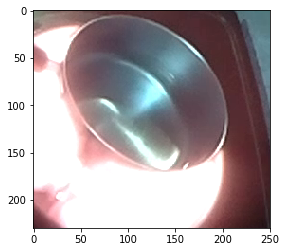

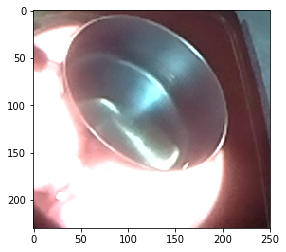

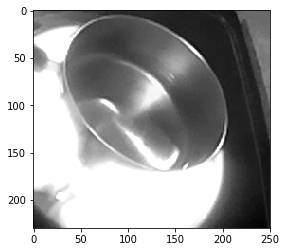

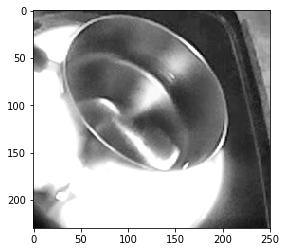

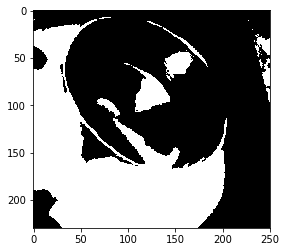

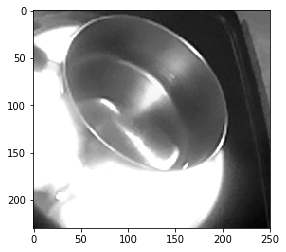

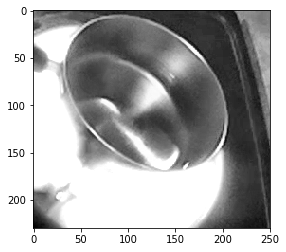

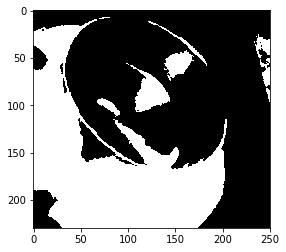

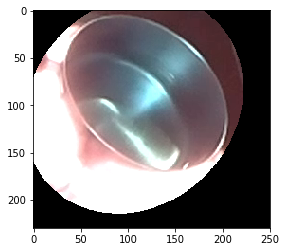

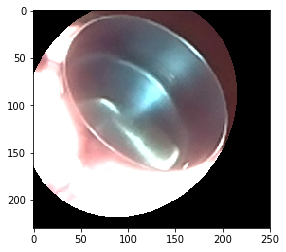

In [201]:
crop1 = captured[70:300, 800:1050]
plt.imshow(crop1)
plt.show()
crop2 = captured2[70:300, 800:1050]
plt.imshow(crop2)
plt.show()
# gets a masked version of the images
mask1 = maskPot(crop1)
mask2 = maskPot(crop2)
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

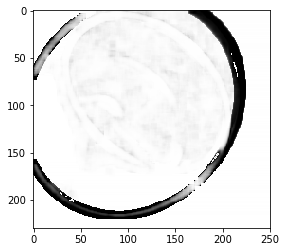

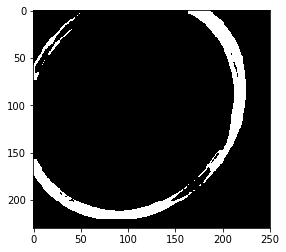

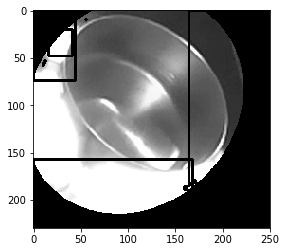

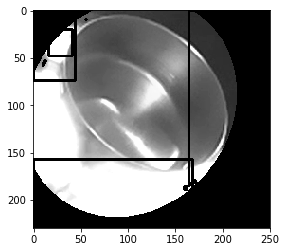


SSIM: 0.9088752920530004


In [202]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

In [203]:
# returns an undistorted image
def undistort(img, balance=0.0, dim2=None, dim3=None):
    K = np.array(
        [[318.5047565963465, 0.0, 304.72174448074446], [0.0, 318.3070269260298, 234.84280567757642], [0.0, 0.0, 1.0]])
    D = np.array([[-0.041193383831182505], [0.012582938251747337], [-0.026474498577198458], [0.020393209710516367]])
    DIM = (480, 640)  # image dimensions

    dim1 = img.shape[:2][::-1]  # dim1 is the dimension of input image to undistort

    if not dim2:
        dim2 = dim1

    if not dim3:
        dim3 = dim1

    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension
    scaled_K[2][2] = 1.0

    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    return undistorted_img

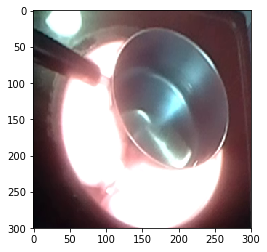

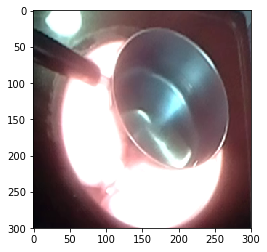

In [215]:
captured = undistort(captured)
captured2 = undistort(captured2)
plt.imshow(captured)
plt.show()
plt.imshow(captured2)
plt.show()

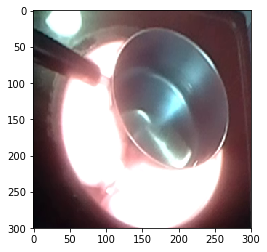

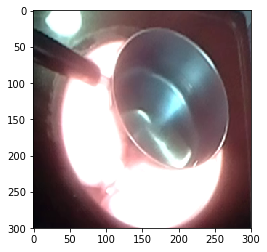

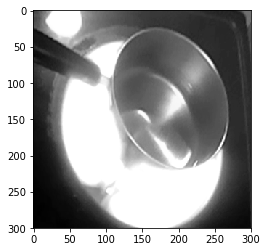

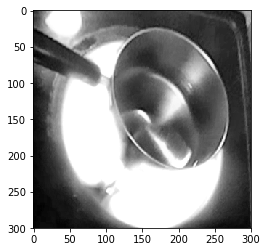

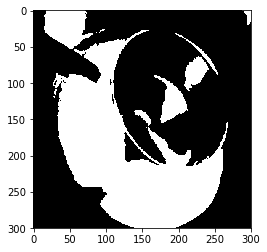

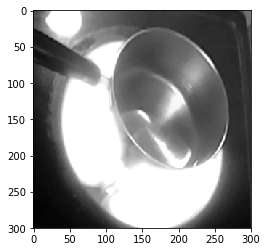

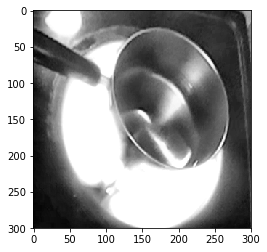

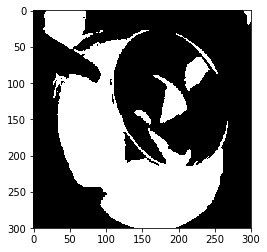

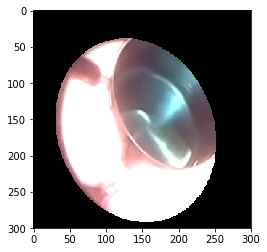

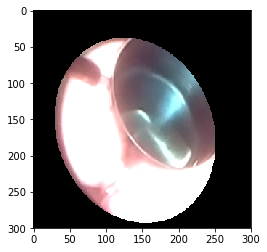

In [217]:
crop1 = captured[100:400, 800:1100]
plt.imshow(crop1)
plt.show()
crop2 = captured2[100:400, 800:1100]
plt.imshow(crop2)
plt.show()
# gets a masked version of the images
mask1 = maskPot(crop1)
mask2 = maskPot(crop2)
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

In [222]:
print(crop1.shape)
print(captured.shape)

(300, 300, 3)
(720, 1280, 3)
